In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve,precision_score, recall_score, confusion_matrix, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from boruta import BorutaPy

import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

from keras import Sequential
from keras.src.layers import Dense, Dropout
from keras.src.optimizers import Adam
from keras.src.callbacks import EarlyStopping

### Data prep

In [3]:
# Load data
data = pd.read_csv('C:/Users/danie/OneDrive/Documentos/1 UNIANDES/10 semestre/Tesis/differential-privacy-banking-sector/data/processed/bank-processed.csv', sep=',')
data.shape

(45211, 33)

In [4]:
# Separate features and target variable
X = data.drop(columns=['y'])
Y = data['y']

# Define numerical features
numeric_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Normalize numerical features
scale = MinMaxScaler()
X[numeric_cols] = scale.fit_transform(X[numeric_cols])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

#### Synthetic Minority Oversampling Technique (SMOTE)

In [5]:
stat = pd.DataFrame(Y.value_counts())
stat['percent'] = stat['count']/Y.shape[0]*100
stat

,count,percent
y,,
0,39922,88.30152
1,5289,11.69848


In [6]:
# Crear el objeto SMOTEENN
smoteenn = SMOTEENN(random_state=42)

# Aplicar la resampleación
X_resample, y_resample = smoteenn.fit_resample(X_train, y_train)

# Convertir a DataFrame para mantener nombres de columnas
X_resample = pd.DataFrame(X_resample, columns=X.columns)
y_resample = pd.Series(y_resample)


In [7]:
stat2 = pd.DataFrame(y_resample.value_counts())
stat2['percent'] = stat2['count']/y_resample.shape[0]*100
stat2

,count,percent
y,,
1,27937,52.214788
0,25567,47.785212


### **Feature Selection**


#### Boruta Algorithm (wrapper)

In [8]:
# Inicializar el modelo de XGBoost asegurando compatibilidad
rf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Configurar BorutaPy
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)

# Ajustar BorutaPy asegurando que Y_resample sea 1D
feat_selector.fit(X_resample.values, y_resample.values.ravel())

# Obtener las características seleccionadas
X_filtered = X.columns[feat_selector.support_].tolist()

c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	23
Tentative: 	9
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	23
Tentative: 	9
Rejected: 	0


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	10 / 100
Confirmed: 	23
Tentative: 	8
Rejected: 	1
Iteration: 	11 / 100
Confirmed: 	23
Tentative: 	8
Rejected: 	1
Iteration: 	12 / 100
Confirmed: 	25
Tentative: 	6
Rejected: 	1


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	13 / 100
Confirmed: 	25
Tentative: 	6
Rejected: 	1
Iteration: 	14 / 100
Confirmed: 	25
Tentative: 	6
Rejected: 	1
Iteration: 	15 / 100
Confirmed: 	25
Tentative: 	6
Rejected: 	1


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	16 / 100
Confirmed: 	25
Tentative: 	6
Rejected: 	1
Iteration: 	17 / 100
Confirmed: 	25
Tentative: 	6
Rejected: 	1
Iteration: 	18 / 100
Confirmed: 	25
Tentative: 	6
Rejected: 	1


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	19 / 100
Confirmed: 	25
Tentative: 	6
Rejected: 	1
Iteration: 	20 / 100
Confirmed: 	25
Tentative: 	6
Rejected: 	1
Iteration: 	21 / 100
Confirmed: 	25
Tentative: 	6
Rejected: 	1


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	22 / 100
Confirmed: 	26
Tentative: 	5
Rejected: 	1
Iteration: 	23 / 100
Confirmed: 	26
Tentative: 	4
Rejected: 	2


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	24 / 100
Confirmed: 	26
Tentative: 	4
Rejected: 	2
Iteration: 	25 / 100
Confirmed: 	26
Tentative: 	4
Rejected: 	2
Iteration: 	26 / 100
Confirmed: 	26
Tentative: 	4
Rejected: 	2


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	27 / 100
Confirmed: 	26
Tentative: 	4
Rejected: 	2
Iteration: 	28 / 100
Confirmed: 	26
Tentative: 	4
Rejected: 	2
Iteration: 	29 / 100
Confirmed: 	26
Tentative: 	4
Rejected: 	2


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	30 / 100
Confirmed: 	26
Tentative: 	4
Rejected: 	2
Iteration: 	31 / 100
Confirmed: 	26
Tentative: 	4
Rejected: 	2
Iteration: 	32 / 100
Confirmed: 	26
Tentative: 	4
Rejected: 	2


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	33 / 100
Confirmed: 	26
Tentative: 	4
Rejected: 	2
Iteration: 	34 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	35 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	36 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	37 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	38 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	39 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	40 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	41 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	42 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	43 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	44 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	45 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	46 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	47 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	48 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	49 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	50 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	51 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	52 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	53 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	54 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	55 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	56 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	57 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	58 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	59 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	60 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	61 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	62 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	63 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	64 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	65 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	66 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	67 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	68 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	69 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	70 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	71 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	72 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	73 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	74 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	75 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	76 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	77 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	78 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	79 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	80 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	81 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	82 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	83 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	84 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	85 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	86 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	87 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	88 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	89 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	90 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	91 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	92 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	93 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	94 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	95 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	96 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	97 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3
Iteration: 	98 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:25:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iteration: 	99 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3


BorutaPy finished running.

Iteration: 	100 / 100
Confirmed: 	26
Tentative: 	3
Rejected: 	3


### Export dataset

In [9]:
# Save filtered and normalized data
filtered_data = X[X_filtered].copy()
filtered_data['y'] = Y

# Save to csv
filtered_path = 'C:/Users/danie/OneDrive/Documentos/1 UNIANDES/10 semestre/Tesis/differential-privacy-banking-sector/data/processed/bank-filtered.csv'
filtered_data.to_csv(filtered_path, index=False)
print(f"Dataset preprocesado guardado en: {filtered_path}")

Dataset preprocesado guardado en: C:/Users/danie/OneDrive/Documentos/1 UNIANDES/10 semestre/Tesis/differential-privacy-banking-sector/data/processed/bank-filtered.csv


### **Hyperparameter Tuning**

### VERSIÓN INICIAL

In [10]:
# Definir modelos
models = { 
    'ElasticNet': LogisticRegression(solver='saga', max_iter=10000),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}

# Definir hiperparámetros
param_grids = {
    'ElasticNet': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
        'penalty': ['elasticnet']
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    },
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'GradientBoosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
}


### Training

Training ElasticNet...


C:\Users\danie\AppData\Local\Temp\ipykernel_26344\3855823.py:17: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  grid_search.fit(X_resample[X_filtered], y_resample.ravel())


Best params for ElasticNet: {'C': 1000, 'l1_ratio': 0.9, 'penalty': 'elasticnet'}
Best ROC AUC score for ElasticNet: 0.948180
Training XGBoost...


C:\Users\danie\AppData\Local\Temp\ipykernel_26344\3855823.py:17: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  grid_search.fit(X_resample[X_filtered], y_resample.ravel())
c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:32:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best params for XGBoost: {'colsample_bytree': 0.6, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Best ROC AUC score for XGBoost: 0.996410
Training RandomForest...


C:\Users\danie\AppData\Local\Temp\ipykernel_26344\3855823.py:17: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  grid_search.fit(X_resample[X_filtered], y_resample.ravel())


Best params for RandomForest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best ROC AUC score for RandomForest: 0.993352
Training GradientBoosting...


C:\Users\danie\AppData\Local\Temp\ipykernel_26344\3855823.py:17: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  grid_search.fit(X_resample[X_filtered], y_resample.ravel())


Best params for GradientBoosting: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Best ROC AUC score for GradientBoosting: 0.996206


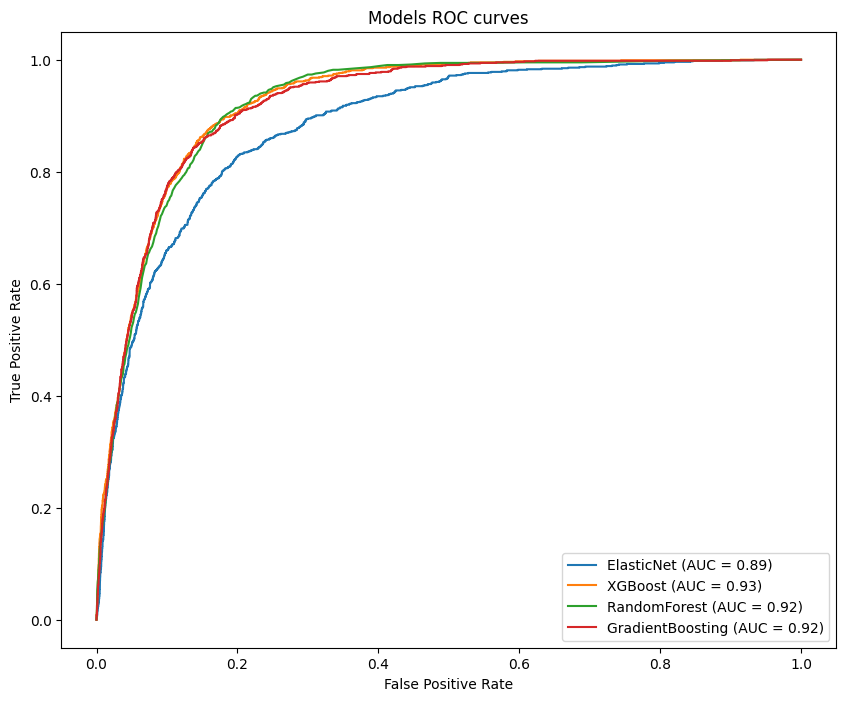


Best overall model: XGBoost with ROC AUC: 0.996410


In [11]:
# Inicializar el gráfico de la curva ROC
plt.figure(figsize=(10, 8))

# k-fold cross-validation
kf = KFold(n_splits=2, shuffle=True, random_state=42)

# Diccionarios para almacenar resultados
results = {}
best_models = {}
best_scores = {}

for model_name, model in models.items():
    print(f'Training {model_name}...')

    # Grid Search con validación cruzada
    grid_search = GridSearchCV(model, param_grids[model_name], cv=kf, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_resample[X_filtered], y_resample.ravel())

    best_models[model_name] = grid_search.best_estimator_
    best_scores[model_name] = grid_search.best_score_

    print(f'Best params for {model_name}: {grid_search.best_params_}')
    print(f'Best ROC AUC score for {model_name}: {grid_search.best_score_:.6f}')

    # Hacer predicciones en el conjunto de prueba
    y_pred = best_models[model_name].predict(X_test[X_filtered])
    y_prob = best_models[model_name].predict_proba(X_test[X_filtered])[:, 1]

    # Confusion matrix en el conjunto de prueba
    conf_matrix = confusion_matrix(y_test, y_pred)
    actual_negatives = conf_matrix[0].sum()
    actual_positives = conf_matrix[1].sum()

    false_positive = conf_matrix[0][1]  # Error Tipo I
    false_negative = conf_matrix[1][0]  # Error Tipo II

    false_positive_pct = (false_positive / actual_negatives) * 100
    false_negative_pct = (false_negative / actual_positives) * 100

    # Guardar resultados en el diccionario
    results[model_name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'Type I Error (%)': false_positive_pct,
        'Type II Error (%)': false_negative_pct,
        'ROC AUC': roc_auc_score(y_test, y_prob),
        'Best Params': grid_search.best_params_
    }

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {results[model_name]['ROC AUC']:.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Models ROC curves')
plt.legend()
plt.show()

# Seleccionar el mejor modelo basado en la métrica ROC AUC
best_model_name = max(best_scores, key=best_scores.get)
best_model = best_models[best_model_name]
print(f'\nBest overall model: {best_model_name} with ROC AUC: {best_scores[best_model_name]:.6f}')


In [18]:
# Convertir resultados a DataFrame y mostrar
results_df = pd.DataFrame.from_dict(results, orient='index').sort_values(by='ROC AUC', ascending=False)
print("\nResultados finales:")
results_df


Resultados finales:


,Accuracy,Precision,Recall,F1 Score,Type I Error (%),Type II Error (%),ROC AUC,Best Params
XGBoost,0.893398,0.533862,0.700378,0.605887,8.102693,29.962193,0.925430,"{'colsample_bytree': 0.6, 'learning_rate': 0.2..."
RandomForest,0.874489,0.477603,0.775992,0.591286,11.246086,22.400756,0.923274,"{'max_depth': None, 'min_samples_leaf': 1, 'mi..."
GradientBoosting,0.893066,0.531663,0.722117,0.612425,8.428303,27.788280,0.922256,"{'learning_rate': 0.2, 'max_depth': 7, 'n_esti..."
ElasticNet,0.811235,0.362558,0.809074,0.500731,18.847840,19.092628,0.886278,"{'C': 1000, 'l1_ratio': 0.9, 'penalty': 'elast..."


In [19]:
y_pred = best_models['RandomForest'].predict(X_test[X_filtered])
y_prob = best_models['RandomForest'].predict_proba(X_test[X_filtered])[:, 1]

# Confusion matrix en el conjunto de prueba
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
print ('[[TN  FP] \n [FN  TP]]')

[[7087  898]
 [ 237  821]]
[[TN  FP] 
 [FN  TP]]


### Red Neuronal

In [ ]:
# Función para construir el modelo
def build_model(input_shape, learning_rate=0.001, dropout_rate=0.2, units=64, activation='relu', hidden_layers=2):
    model = Sequential()
    model.add(Dense(units, activation=activation, input_shape=(input_shape,)))
    model.add(Dropout(dropout_rate))
    
    for _ in range(hidden_layers - 1):  
        model.add(Dense(units, activation=activation))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['AUC'])
    return model

# Parámetros de la red neuronal
params = {'learning_rate': 0.001, 'dropout_rate': 0.2, 'units': 128, 'activation': 'relu', 'hidden_layers': 3}

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Convertir datos a numpy
X_resample_np = X_resample[X_filtered].to_numpy()
Y_resample_np = y_resample.to_numpy()

# Train-validation split
X_train, X_val, Y_train, Y_val = train_test_split(X_resample_np, Y_resample_np, test_size=0.2, random_state=42)

# Construcción y entrenamiento del modelo
model = build_model(input_shape=X_train.shape[1], **params)

history = model.fit(
    X_train, Y_train,
    epochs=50, batch_size=32,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Predicciones en el conjunto de validación
y_true = Y_val
y_pred = (model.predict(X_val) > 0.5).astype(int).ravel()
y_prob = model.predict(X_val).ravel()

# Cálculo de métricas
conf_matrix = confusion_matrix(y_true, y_pred)
actual_negatives = conf_matrix[0].sum()
actual_positives = conf_matrix[1].sum()

false_positive = conf_matrix[0][1]  # Error Tipo I
false_negative = conf_matrix[1][0]  # Error Tipo II

false_positive_pct = (false_positive / actual_negatives) * 100
false_negative_pct = (false_negative / actual_positives) * 100

roc_auc = roc_auc_score(y_true, y_prob)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Diccionario de resultados
results = {
    'Neural Network': {
        'ROC AUC': roc_auc,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Type I Error': false_positive_pct,
        'Type II Error': false_negative_pct
    }
}

# Graficar curva ROC
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.plot(fpr, tpr, label=f"Neural Network (AUC = {roc_auc:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Graficar evolución de loss y AUC
epochs = range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(12, 5))

# Pérdida (Loss)
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], 'b-', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolución de la Pérdida')
plt.legend()

# AUC
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['auc'], 'b-', label='Training AUC')
plt.plot(epochs, history.history['val_auc'], 'r-', label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Evolución del AUC')
plt.legend()

plt.show()

# Mostrar tabla de métricas
df_results = pd.DataFrame(results).T
print(df_results)
